In [2]:
import os
import pandas_datareader as pdr

import warnings
warnings.filterwarnings("ignore")

api_key='2280379fbc6af748da8dc346c3c46189e670e9fc'

In [3]:
SPY = pdr.get_data_tiingo('SPY', api_key=api_key)
SPY = SPY.reset_index(level=[0,1])
SPY.index = SPY['date']
SPY_adj = SPY.iloc[:,7:11]
SPY_adj.columns = ['Close','High','Low','Open']

In [4]:
def Evening_Star_Sig(data):
    # 開盤價/收盤價
    data_Open = data.Open
    data_Close = data.Close
    
    # 當日漲跌
    data_DailyChg = data_Close - data_Open
    
    # 取得每日的振幅
    data_Abs_DailyChg = abs(data_DailyChg)
    
    # 計算統計數據
    mean = data_Abs_DailyChg.mean()
    first_quar = data_Abs_DailyChg.quantile(q=0.25)
    
    # 抓取 第1根大振幅陽線、第2根小振幅陽線或陰線、第3根陰線且振幅大於第1根的1/2
    evening_condition_1 = [0,0]
    for i in range(2, len(data_DailyChg)):
        if ( data_DailyChg[i-2] > mean ) & ( abs(data_DailyChg[i-1]) < first_quar ) & ( data_DailyChg[i] < -0.5*mean ):
            evening_condition_1.append(1)
        else:
            evening_condition_1.append(0)
            
    # 第2根的開盤與收盤價 均大於 第1根的收盤與第3根的開盤
    evening_condition_2 = [0,0]
    for i in range(2, len(data_Open)):
        if ( data_Open[i-1] > data_Close[i-2] ) & ( data_Open[i-1] > data_Open[i] ) & ( data_Close[i-1] > data_Close[i-2] ) & ( data_Close[i-1] > data_Open[i] ):
            evening_condition_2.append(1)
        else:
            evening_condition_2.append(0)
            
    # Evening Star Signal
    evening_star_signal = []
    for i in range(len(evening_condition_1)):
        if ( evening_condition_1[i] == 1 ) & ( evening_condition_2[i] == 1 ):
            evening_star_signal.append(1)
        else:
            evening_star_signal.append(0)
            
    # Return a boolean series
    import pandas as pd
    sig = pd.Series(index = data.index, data = evening_star_signal)
    sig = sig.astype('bool')
    return sig

In [5]:
#以開盤價計算
SPY_Open_adj = SPY_adj.Open
#隔日沖
ret1 = SPY_Open_adj.shift(-2) / SPY_Open_adj.shift(-1)
#隔5天賣
ret5 = SPY_Open_adj.shift(-6) / SPY_Open_adj.shift(-1)

In [6]:
sig = Evening_Star_Sig(SPY_adj)
sig

date
2016-05-06 00:00:00+00:00    False
2016-05-09 00:00:00+00:00    False
2016-05-10 00:00:00+00:00    False
2016-05-11 00:00:00+00:00    False
2016-05-12 00:00:00+00:00    False
                             ...  
2021-04-28 00:00:00+00:00    False
2021-04-29 00:00:00+00:00    False
2021-04-30 00:00:00+00:00    False
2021-05-03 00:00:00+00:00    False
2021-05-04 00:00:00+00:00    False
Length: 1257, dtype: bool

In [7]:
ret1[sig]

date
2018-04-06 00:00:00+00:00    1.011095
2018-06-21 00:00:00+00:00    0.991947
2018-10-18 00:00:00+00:00    0.999531
2019-08-20 00:00:00+00:00    1.002564
2020-10-26 00:00:00+00:00    0.977455
2021-04-19 00:00:00+00:00    0.994202
Name: Open, dtype: float64

In [8]:
ret5[sig]

date
2018-04-06 00:00:00+00:00    1.021540
2018-06-21 00:00:00+00:00    0.987158
2018-10-18 00:00:00+00:00    0.959550
2019-08-20 00:00:00+00:00    0.978323
2020-10-26 00:00:00+00:00    0.982134
2021-04-19 00:00:00+00:00    1.009712
Name: Open, dtype: float64

Text(0.5, 0, 'Interval Day Count')

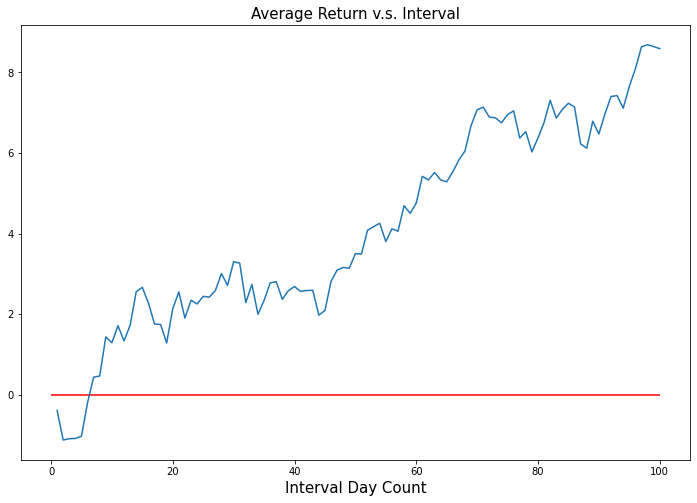

In [9]:
# 回測 Evening star出現後，買賣間隔1~100天的平均報酬率
rets = []
for i in range(2,102):
    ret = SPY_Open_adj.shift(-i) / SPY_Open_adj.shift(-1)
    rets.append(ret[sig].mean())
    
# 畫出天數對應報酬率的圖
import pandas as pd
import matplotlib.pyplot as plt
ret_df = pd.DataFrame(index=range(1,101),data=rets)
ret_df.columns = ['return']
ret_df = (ret_df-1) * 100
plt.figure(figsize=(12,8))
plt.plot(ret_df)
plt.hlines(y=0, xmin=0, xmax=100, color='red')
plt.title("Average Return v.s. Interval",fontsize=15)
plt.xlabel("Interval Day Count", fontsize=15)
